In [23]:
# nuclio: ignore
import nuclio

In [24]:
%nuclio config kind = "job"
%nuclio config spec.build.baseImage = "mlrun/ml-models"

%nuclio: setting kind to 'job'
%nuclio: setting spec.build.baseImage to 'mlrun/ml-models'


In [25]:
%%nuclio cmd -c
python -m pip install lifelines

In [26]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [27]:
from mlutils import (get_sample,
                     get_splits,
                     gen_sklearn_model,
                     create_class, 
                     eval_class_model,
                     gcf_clear)

from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from mlrun.artifacts import PlotArtifact, TableArtifact

from cloudpickle import dumps
import pandas as pd
import os

from lifelines import CoxPHFitter, KaplanMeierFitter

## train

In [28]:
def _coxph_log_model(
    context,
    model, 
    dataset_key: str  = "coxhazard-summary",
    models_dest: str = "models",
    plot_cov_groups: bool = False,
    p_value: float = 0.005,
    plot_key: str  = "km-cx",
    plots_dest: str = "plots",
    file_ext="csv",
    extra_data: dict = {}
):
    """log a coxph model (and submodel locations)
    
    :param extra_data:   if this model wants to store the locations of submodels
                         use this
    """
    import matplotlib.pyplot as plt
    
    sumtbl = model.summary
    
    context.log_dataset(dataset_key, df=sumtbl,
                        index=True, format=file_ext)

    model_bin = dumps(model)
    context.log_model("model", body=model_bin, 
                      artifact_path=os.path.join(context.artifact_path, models_dest),
                      # model_dir=models_dest, 
                      model_file="model.pkl")
    # this will look at regression estimate stats and select, based on p_values,
    # only those covariates of interest and display a plot for each vs all
    # stratification group combos (~15 charts per stratification variable => 60 charts)
    if plot_cov_groups:
        select_covars = summary[summary.p<=p_value].index.values
        for group in select_covars:
            axs = model.plot_covariate_groups(group, values=[0, 1])
            for ix, ax in enumerate(axs):
                f = ax.get_figure()
                context.log_artifact(
                    PlotArtifact(f"cx-{group}-{ix}", body=plt.gcf()), 
                    local_path=f"{plots_dest}/cx-{group}-{ix}.html")
                gcf_clear(plt)

In [29]:
def _kaplan_meier_log_model(
    context,
    model, 
    time_column: str = "tenure",
    dataset_key: str  = "km-timelines",
    plot_key: str  = "km-survival",
    plots_dest: str = "plots",
    models_dest: str = "models",
    file_ext: str = "csv"
):
    import matplotlib.pyplot as plt
    o = []
    for obj in model.__dict__.keys():
        if isinstance(model.__dict__[obj], pd.DataFrame):
            o.append(model.__dict__[obj])
    df = pd.concat(o, axis=1)
    df.index.name = time_column
    context.log_dataset(dataset_key, df=df, index=True, format=file_ext)
    # plot the model and grab figure
    model.plot()
    context.log_artifact(PlotArtifact(plot_key, body=plt.gcf()), 
                         local_path=f"{plots_dest}/{plot_key}.html")
    # log model
    context.log_model("model", 
                      body=dumps(model), 
                      model_dir=f"{models_dest}/km", 
                      model_file="model.pkl")

In [30]:
def train_model(
    context: MLClientCtx,
    dataset: DataItem,
    event_column: str = "labels",
    time_column: str = "tenure",
    encode_cols: dict = {},
    strata_cols: list = [],
    plot_cov_groups: bool = False,
    p_value: float = 0.005,
    enc_drop_first: bool = True,
    sample: int = -1,
    test_size: float = 0.25,
    valid_size: float = 0.75, # (after test removed)
    random_state: int = 1,
    models_dest: str = "",
    plots_dest: str = "",
    file_ext: str = "csv",
) -> None:
    """train models to predict the timing of events
    
    Although identical in structure to other training functions, this one
    requires generating a 'Y' that represents the age/duration/tenure of
    the obervation, designated 'tenure' here, and a binary labels columns that
    represents the event of interest, churned/not-churned.
    
    In addition, there is a strata_cols parameter, representing a list of 
    stratification (aka grouping) variables.
    
    :param context:           the function context
    :param dataset:           ("data") name of raw data file
    :param event_column:      ground-truth (y) labels (considered as events in this model)
    :param time_column:       age or tenure column
    :param encode_cols:       dictionary of names and prefixes for columns that are
                              to hot be encoded. (diff strata_cols)
    :param enc_drop_first:    (True) whether to drop the first column of hot encoded 
                              variables (avoid column exact dependencies)
    :param strata_cols:       columns used to stratify analysis (aka groups)
    :param p_value:           (0.005) max p value for coeffcients selected
    :param sample:            Selects the first n rows, or select a sample
                              starting from the first. If negative <-1, select
                              a random sample
    :param test_size:         (0.25) test set size
    :param valid_size:        (0.75) Once the test set has been removed the
                              training set gets this proportion.
    :param random_state:      (1) sklearn rng seed
    :param models_dest:       destination subfolder for model artifacts
    :param plots_dest:        destination subfolder for plot artifacts
    :param file_ext:          format for test_set_key hold out data
    """
    from lifelines.plotting import plot_lifetimes
    import matplotlib.pyplot as plt
    
    # deprecate:
    models_dest = models_dest or "models"
    plots_dest = plots_dest or f"plots/{context.name}"
    
    # get a sample from the raw data, Y is defined as tenure
    raw, tenure, header = get_sample(dataset, sample, time_column)

    # hot-encode
    if encode_cols:
        raw = pd.get_dummies(raw, 
                             columns=list(encode_cols.keys()), 
                             prefix=list(encode_cols.values()), 
                             drop_first=enc_drop_first)

    # split the sample into train validate, test and calibration sets:
    (xtrain, ytrain), (xvalid, yvalid), \
        (xtest, ytest), _ = get_splits(raw, tenure, 3, test_size, 
                                       valid_size, [time_column],
                                       random_state)
    # removed mapped version of tenure
    for X in [xtrain, xvalid, xtest]:
        drop_cols = X.columns.str.startswith(time_column)
        X.drop(X.columns[drop_cols], axis=1, inplace=True)
    for Y in [ytrain, yvalid, ytest]:
        Y.name = time_column
    
    # save test data
    context.log_dataset("tenured-test-set", 
                        df=pd.concat([xtest, ytest.to_frame()], axis=1), 
                        format=file_ext, index=False)

    # KAPLAN-MEIER
    km_model = KaplanMeierFitter().fit(ytrain, xtrain.labels)
    _kaplan_meier_log_model(context, km_model, models_dest=models_dest)
    
    # COXPH
    coxdata = pd.concat([xtrain, ytrain.to_frame()], axis=1)
    cx_model = CoxPHFitter().fit(coxdata, time_column, event_column, strata=strata_cols)    
    _coxph_log_model(context, cx_model, models_dest=models_dest, 
                     plot_cov_groups=plot_cov_groups, 
                     extra_data={"km": f"{models_dest}/km"})

In [31]:
# nuclio: end-code

### mlconfig

In [32]:
from mlrun import mlconf
import os
mlconf.dbpath = mlconf.dbpath or "http://mlrun-api:8080"
mlconf.artifact_path = mlconf.artifact_path or f"{os.environ['HOME']}/artifacts"

### save

In [33]:
from mlrun import code_to_function 
# create job function object from notebook code
fn = code_to_function("cox_hazards")

# add metadata (for templates and reuse)
fn.spec.default_handler = "train_model"
fn.spec.description = "train any classifier using scikit-learn's API"
fn.metadata.categories = ["training", "ml"]
fn.metadata.labels = {"author": "yjb", "framework": "survival"}

fn.export("function.yaml")

[mlrun] 2020-05-12 22:52:26,650 function spec saved to path: function.yaml


### test function

In [34]:
if "V3IO_HOME" in list(os.environ):
    # mlrun on the iguazio platform
    from mlrun import mount_v3io
    fn.apply(mount_v3io())
else:
    # mlrun is setup using the instructions at 
    # https://github.com/mlrun/mlrun/blob/master/hack/local/README.md
    from mlrun.platforms import mount_pvc
    fn.apply(mount_pvc("nfsvol", "nfsvol", "/home/joyan/data"))

In [35]:
task_params = {
    "name" : "tasks survive trainer",
    "params" : {
        "event_column" : "labels", 
        "strata_cols" : ['InternetService', 'StreamingMovies', 'StreamingTV', 'PhoneService'],
        "p_value"     : 0.005,
        "encode_cols" : {"Contract"       : "Contract",
                         "PaymentMethod"  : "Payment"},
        "models_dest" : 'models/cox',
        "file_ext" : "csv"}}

### run locally

[mlrun] 2020-05-12 22:52:27,444 starting run tasks survive trainer uid=49114e9ca3c049fbb18dd37295e4e44d  -> http://mlrun-api:8080


/conda/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[mlrun] 2020-05-12 22:52:27,647 log artifact tenured-test-set at /User/artifacts/churn/tenured-test-set.csv, size: 85274, db: Y
[mlrun] 2020-05-12 22:52:27,752 log artifact km-timelines at /User/artifacts/churn/km-timelines.csv, size: 14130, db: Y
[mlrun] 2020-05-12 22:52:27,847 log artifact km-survival at /User/artifacts/churn/plots/km-survival.html, size: 10286, db: Y
[mlrun] 2020-05-12 22:52:27,888 log artifact model at /User/artifacts/churn/models/cox/km/, size: 107640, db: Y
[mlrun] 2020-05-12 22:52:29,288 log artifact coxhazard-summary at /User/artifacts/churn/coxhazard-summary.csv, size: 3429, db: Y
[mlrun] 2020-05-12 22:52:29,329 log artifact model at /User/artifacts/churn/models/cox/, size: 340838, db: Y



project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...95e4e44d,0,May 12 22:52:27,completed,tasks survive trainer,v3io_user=adminkind=handlerowner=adminhost=jupyter-55f958bc89-rz5cz,dataset,"event_column=labelsstrata_cols=['InternetService', 'StreamingMovies', 'StreamingTV', 'PhoneService']p_value=0.005encode_cols={'Contract': 'Contract', 'PaymentMethod': 'Payment'}models_dest=models/coxfile_ext=csv",,tenured-test-setkm-timelineskm-survivalmodelcoxhazard-summary


to track results use .show() or .logs() or in CLI: 
!mlrun get run 49114e9ca3c049fbb18dd37295e4e44d --project default , !mlrun logs 49114e9ca3c049fbb18dd37295e4e44d --project default
[mlrun] 2020-05-12 22:52:29,439 run executed, status=completed


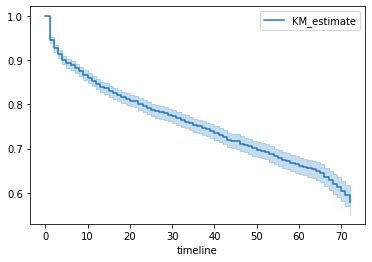

In [36]:
from mlrun import run_local, NewTask

run = run_local(
    NewTask(**task_params),
    handler=train_model,
    inputs={"dataset"  : "./encoded-data.csv"},
    artifact_path=os.path.join(mlconf.artifact_path, "churn"))

## a peek at a kaplan-meier model

In [37]:
from cloudpickle import load
model = load(open(os.path.join(mlconf.artifact_path, "churn", "models/cox/km/model.pkl"), "rb"))
model

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3954 total observations, 2897 right-censored observations>

In [38]:
model.predict([1,10,30,100,200])

1      0.945878
10     0.859838
30     0.773100
100    0.579614
200    0.579614
Name: KM_estimate, dtype: float64

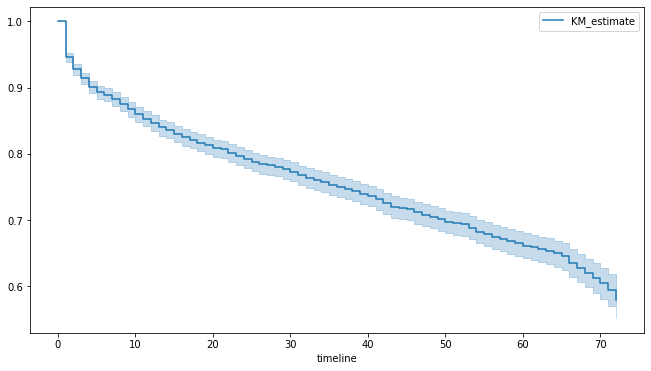

In [39]:
m = model.plot(figsize=(11,6))

## a peek at a cox hazards default model

In [40]:
from cloudpickle import load
model = load(open(os.path.join(mlconf.artifact_path, "churn", "models/cox/model.pkl"), "rb"))
model

<lifelines.CoxPHFitter: fitted with 3954 total observations, 2897 right-censored observations>

In [41]:
model.print_summary()

### some potential default analyses of coxph

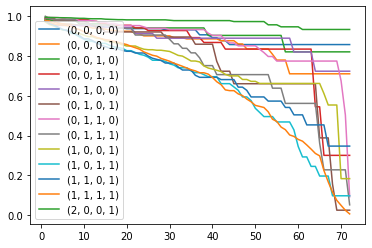

In [42]:
model.baseline_survival_.plot()

* run the following for each of the lines that passes some test (p < 0.005,for example):<br>
 `model.plot_covariate_groups('Contract_1', values=[0, 1]);`<br>
 the plot needs to have the strata decoded
 
 In the train_model above, set param `plot_cov_groups=True` and produce the following set of artifacts by selecting only those covariates whose p-values
 are below some threshold `p_value`

In [22]:
# import matplotlib.pyplot as plt
# # need to add strata labels baseline legend
# ax = model.plot_covariate_groups('Contract_1', values=[0, 1])
# len(ax)